# Introduction

This notebook is inspired by the computations realized by H. R. Gordon and M. Wang for the SeaWiFS satellite and it illustrates the use of the `pyOSOAA` python library.

The objetive here is to simulate the ocean-atmosphere system for a completely absorving ocean and from that be able to separate the glint, molecular and aerosol reflectances.

## Simple radiative transfer equation

A simple radiative transfer model for the top of the atmosphere radiance is given by

$$ \rho_t = \rho_r + \rho_a + \rho_{ra} + \rho_g + t\rho_w$$

where

$$\rho = \frac{\pi L}{F_0 \cos\theta_0}$$

and the subindices represent

- t  : Top of the atmosphere
- r  : molecular scattering
- a  : aerosol scattering
- ra : aerosol-molecular coupled scattering
- g  : glint
- w  : water

for a black ocean where $\rho_t \sim 0$ the component $\rho_a + \rho_{ra}$ can be solved from this equation.

We aim to do this in the present work for the SeaWiFS wavelengths.

In [1]:
import numpy as np
import pyOSOAA
from pyOSOAA.osoaahelpers import RunWavelengths
import matplotlib.pyplot as plt

We first test the OSOAA instalation.

In [2]:
pyOSOAA.test()

OSOAA wrapper script by Francisco Nemiña
Inspired by Py6S wrapper by Robin Wilson
Using OSOAA located at /home/fnemina/Documents/SABIA-Mar/RT/OSOAA_V1.5
Running OSOAA using a set of test parameters
The results are:
Expected result: 0.128266
Actual result: 0.128266
#### Results agree, PyOSOAA is working correctly


# Geometric configuration

We will start by defining the basic `pyOSOAA` object, along with the wavelengths used in the script and the angles.

In [3]:
# pyOSOAA object
s = pyOSOAA.OSOAA()

In [4]:
# We define SeaWiFS central wavelentghts
view = 0
wavelengths = np.array([412, 443, 490, 510, 555, 670, 765, 865])/1000

In [5]:
# Angles configuration
s.view.phi = 90
s.ang.thetas = 60

# Black ocean

The first calculation is to define a set of parameters that let us compute a black ocean. To do it we create a very shallow ocean with no bottom albedo and no disolved material of any kind. We also set the wind speed to 10m/s

In [6]:
# Sea bottom configuration
s.sea.depth = 0.05
s.sea.bottype = 1
s.sea.botalb = 0

# Sea particles configuration
s.phyto.chl = 0
s.sed.csed = 0
s.det.abs440 = 0
s.ys.abs440 = 0

# Sea surface configuration
s.sea.wind = 10

We will compute the reflectance both above (view level 3) and below (view level 4) the sea surface.

In [7]:
# Configure view level below the surface
s.view.level = 3
rhowg = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

# Configure view level below the surface
s.view.level = 4
rhowl = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

We see that the reflectance below the sea surface, equal to the water leaving radiance, is negligible next to the reflectance just above the surface, that includes the glint component

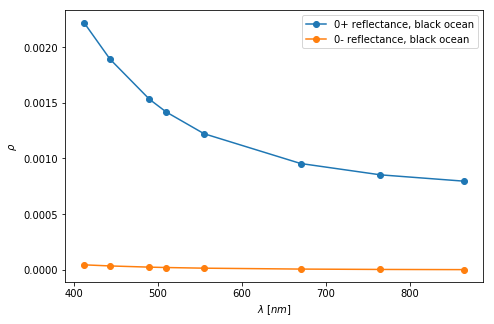

In [8]:
plt.figure(figsize=(7.5,5))
plt.plot(wavelengths*1e3,rhowg,'o-',label="0+ reflectance, black ocean")
plt.plot(wavelengths*1e3,rhowl,'o-',label="0- reflectance, black ocean")
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\rho$"); plt.legend()
plt.show()

We will continue using this ocean configuration during this case study.

# Glint reflectance

We want to now compute the glint reflectance, to do this we will compute the water leaving radiance for a very low aerosol and molecular optical thickness just above the sea surface

In [9]:
# Small optical thickness
s.ap.SetMot(0.0005)
s.aer.aotref = 0.00001
# View level
s.view.level = 4
rhog = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

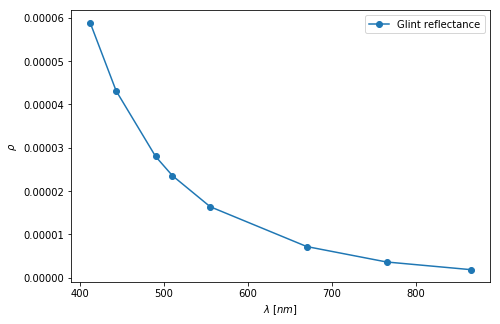

In [10]:
plt.figure(figsize=(7.5,5))
plt.plot(wavelengths*1e3,rhog,'o-',label="Glint reflectance")
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\rho$"); plt.legend()
plt.show()

As we can see the glint reflectance behaves as spected.

# Molecular scattering

We now compute the molecular scattering effect by setting the pressure to a standar pressure and the level at the top of the atmosphere

In [11]:
# Small optical thickness
s.ap.SetPressure(1013.25)

# Set view level at TOA
s.view.level = 1
rhor = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

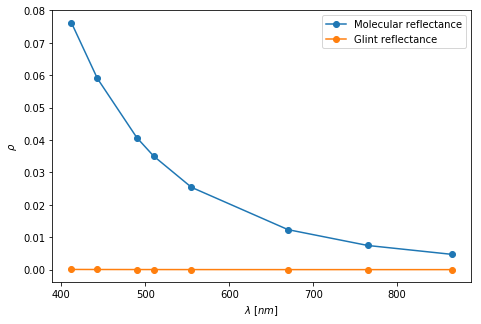

In [12]:
plt.figure(figsize=(7.5,5))
plt.plot(wavelengths*1e3,rhor,'o-',label="Molecular reflectance")
plt.plot(wavelengths*1e3,rhog,'o-',label="Glint reflectance")
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

We again see that the glint reflectance, for the current geometric configuration is negligible and we can ignore it for what follow.

# Aerosol scattering 

We now compute the aerosol scattering effect by setting the aerosol optical thickness to a nonzero value and the molecular optical thickness to zero.

In [13]:
# We set the aerosol optical thickness
s.aer.aotref = 0.1
s.ap.SetMot(0.0005)

# Set view level at TOA
s.view.level = 1

In [14]:
# Define aerosol models to compute
AerosolModels = {"T70":(1,70), "T90":(1,90), "T98":(1,98),
                 "M70":(3,70), "M90":(3,90), "M98":(3,98),
                 "C70":(4,70), "C90":(4,90), "C98":(4,98)}

color = {"T70":"v-C0", "T90":"v-C1", "T98":"v-C2",
         "M70":"o-C0", "M90":"o-C1", "M98":"o-C2",
         "C70":"s-C0", "C90":"s-C1", "C98":"s-C2"}

In [15]:
# Run the different models
results = {}

for key in AerosolModels.keys():
    model = AerosolModels[key]
    s.aer.SetModel(model=2, sfmodel=model[0], rh=model[1])
    results[key] = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

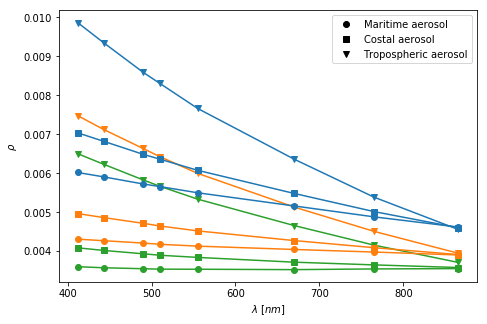

In [16]:
plt.figure(figsize=(7.5,5))
plt.plot([],[],'ok',label="Maritime aerosol")
plt.plot([],[],'sk',label="Costal aerosol")
plt.plot([],[],'vk',label="Tropospheric aerosol")

for key in results.keys():
    plt.plot(wavelengths*1e3, results[key], color[key])
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\rho$"); plt.legend()
plt.show()

We can also compute the $\epsilon(\lambda,865)$ values as computed by Gordon-Wang.

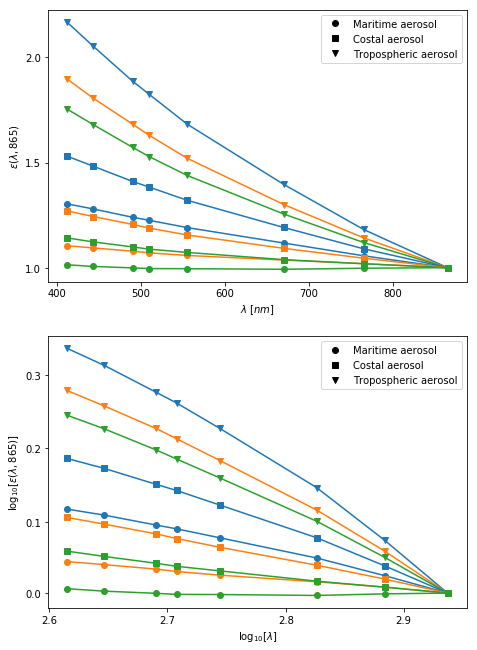

In [17]:
plt.figure(figsize=(7.5,11))
plt.subplot(2, 1, 1)
for key in results.keys():
    plt.plot(wavelengths*1e3, results[key]/results[key][-1], color[key])
plt.xticks([400,500,600,700,800]); plt.yticks([1.0,1.5,2.0])
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\epsilon(\lambda,865)$")
plt.plot([],[],'ok',label="Maritime aerosol")
plt.plot([],[],'sk',label="Costal aerosol")
plt.plot([],[],'vk',label="Tropospheric aerosol")
plt.legend()
plt.subplot(2, 1, 2)
for key in results.keys():
    plt.plot(wavelengths*1e3, results[key]/results[key][-1], color[key])
plt.loglog(basex=10,basey=10,subsx=[0],subsy=[0])
plt.xticks([398,501,631,794],[2.6,2.7,2.8,2.9])
plt.yticks([1,1.25,1.58,1.99,2.51],[0.0,0.1,0.2,0.3,0.4])
plt.xlabel(r"$\log_{10}[\lambda]$")
plt.ylabel(r"$\log_{10}[\epsilon(\lambda,865)]$")
plt.plot([],[],'ok',label="Maritime aerosol")
plt.plot([],[],'sk',label="Costal aerosol")
plt.plot([],[],'vk',label="Tropospheric aerosol")
plt.legend()
plt.show()

# Total scatering

We can now compute the total scatering by adding each component and by performing the simulation. We will do this for the maritime model with 90% relative humidity.

In [18]:
# We set the aerosol and molecular optical thickness
s.aer.aotref = 0.1
s.ap.SetPressure(1013.25)

key = "M90"
# Set aerosol model
model = AerosolModels[key]
s.aer.SetModel(model=2, sfmodel=model[0], rh=model[1])

# Set view level at TOA
s.view.level = 1
rhot = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

We also compute the transmitances for the molecular and aerosol model. We use $\tau_a = 0.1$ for all bands as the aerosol optical thickness.

In [19]:
taur = np.array([0.317976, 0.235460, 0.15540,
                 0.131940, 0.093379, 0.04341,
                 0.025863, 0.015460])
Tr = np.exp(-(taur+0.1)*(1/np.cos(np.pi*view/180.0)
                   +1/np.cos(np.pi*s.ang.thetas/180.0)))
tr = np.exp(-taur/2*(1/np.cos(np.pi*view/180.0)
                   +1/np.cos(np.pi*s.ang.thetas/180.0)))

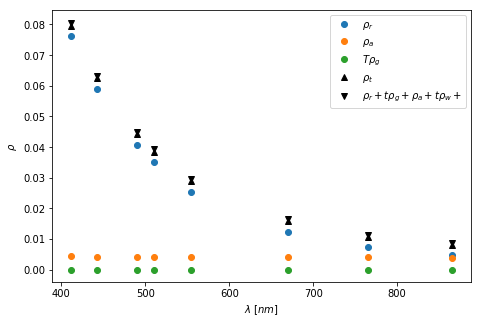

In [20]:
plt.figure(figsize=(7.5,5))
plt.plot(wavelengths*1e3, rhor-Tr*rhog, 'o', label=r"$\rho_r$")
plt.plot(wavelengths*1e3, results["M90"], 'o', label=r"$\rho_a$")
plt.plot(wavelengths*1e3, Tr*rhog, 'o', label=r"$T\rho_g$")
plt.plot(wavelengths*1e3, rhot, '^k', label=r"$\rho_t$")
plt.plot(wavelengths*1e3, rhor+results[key]+rhowl*tr, 'vk',
         label=r"$\rho_r + t\rho_g + \rho_a + t\rho_w + $")

plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

Were the small difference we have is of order $0.001$ and comes from not taking into account the molecular and aerosol scattering interaction.